In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from numpy import save
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from urllib import request,error
from urllib.parse import urlparse
import json
import math
import sys
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets
import PIL
from PIL import Image
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
driveroot = "drive/MyDrive/COMP9417/dataset/train"
cleanroot = os.path.join(driveroot,"clean")
transformed = os.path.join(driveroot,"transformed")

In [ ]:
# X_data = []
# y_data = []

# for label,landmark_id in zip(range(len(os.listdir(cleanroot))),os.listdir(cleanroot)):
#   for file in os.listdir(os.path.join(cleanroot,landmark_id)):
#     if file.lower().endswith("jpg") or file.lower().endswith("jpeg") or file.lower().endswith("png"):
#       filepath = os.path.join(cleanroot,landmark_id,file)
#       img = resize(filepath)
#       X_data.append(img)
#       y_data.append(label)
#   print(landmark_id,'finished')

# save(os.path.join(transformed,"X_data.npy"),X_data)
# save(os.path.join(transformed,"y_data.npy"),y_data)

In [ ]:
# X_data = np.load(os.path.join(transformed,'X_data.npy'))          
# y_data = np.load(os.path.join(transformed,'y_data.npy'))
# X_data = np.swapaxes(X_data,3,1)
# X_tensor = torch.tensor(np.array(X_data))           
# y_tensor = torch.tensor(np.array(y_data))

# X_tensor = X_tensor.to(device)          
# y_tensor = y_tensor.to(device)

# X_train, X_rem, y_train, y_rem = train_test_split(X_tensor,y_tensor, train_size=0.6,shuffle=True)
# X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [ ]:
# save(os.path.join(transformed,"raw","X_train.npy"),X_train)
# save(os.path.join(transformed,"raw","y_train.npy"),y_train)
# save(os.path.join(transformed,"raw","X_val.npy"),X_val)
# save(os.path.join(transformed,"raw","y_val.npy"),y_val)
# save(os.path.join(transformed,"raw","X_test.npy"),X_test)
# save(os.path.join(transformed,"raw","y_test.npy"),y_test)

In [5]:
X_train = np.load(os.path.join(transformed,"raw",'X_train.npy'))          
y_train = np.load(os.path.join(transformed,"raw",'y_train.npy'))
X_test = np.load(os.path.join(transformed,"raw",'X_test.npy'))          
y_test = np.load(os.path.join(transformed,"raw",'y_test.npy'))
X_val = np.load(os.path.join(transformed,"raw",'X_val.npy'))          
y_val = np.load(os.path.join(transformed,"raw",'y_val.npy'))

In [ ]:
class SiftDetector():
    def __init__(self, norm="L2", params=None):
        self.detector=self.get_detector(params)
        self.norm=norm

    def get_detector(self, params):
        if params is None:
            params={}
            params["n_features"]=0
            params["n_octave_layers"]=3
            params["contrast_threshold"]=0.03
            params["edge_threshold"]=10
            params["sigma"]=1.6

        detector = cv2.SIFT_create(
                nfeatures=params["n_features"],
                nOctaveLayers=params["n_octave_layers"],
                contrastThreshold=params["contrast_threshold"],
                edgeThreshold=params["edge_threshold"],
                sigma=params["sigma"])

        return detector

def rotate(image, x, y, angle):
    rot_matrix = cv2.getRotationMatrix2D((x, y), angle, 1.0)
    h, w = image.shape[:2]

    return cv2.warpAffine(image, rot_matrix, (w, h))

def get_img_center(image):
    height, width = image.shape[:2]
    center = height // 2, width // 2
    return center


def preprocessing(img, sift_detector = None, ):
    sift = sift_detector
    if sift_detector is None:
        sift =  SiftDetector()

    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    detector = sift.get_detector(None)
    kp,dp = detector.detectAndCompute(gray,None ) 
    return kp,dp

def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

(1200,)


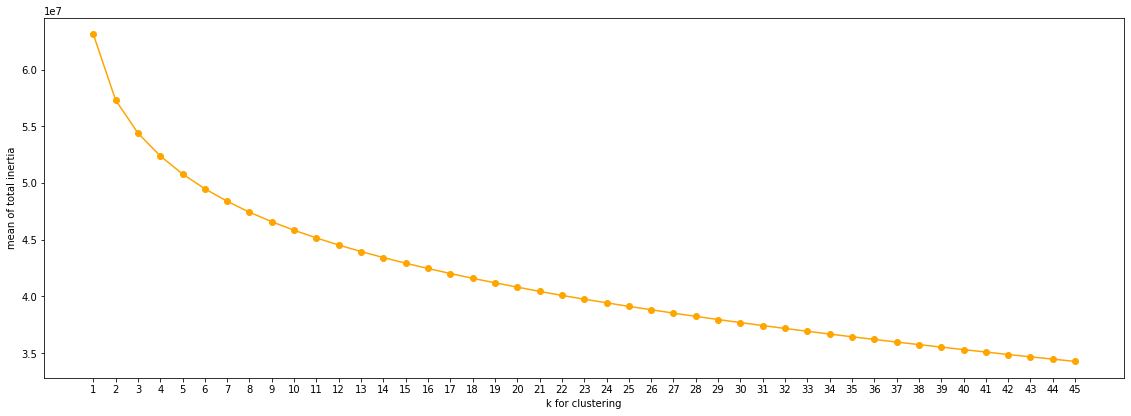

In [ ]:

x = [np.concatenate((np.load(os.path.join(transformed,f'inertias={i}_train.npy')),
                    np.load(os.path.join(transformed,f'inertias={i}_test.npy')),
                    np.load(os.path.join(transformed,f'inertias={i}_val.npy'))),axis=None)  for i in range(1,46,1)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15, 0.1, 1.5, 0.5])
ax.set_xticks(np.arange(1,46,1))
ax.set_xlabel("k for clustering")
ax.set_ylabel("mean of total inertia")
ax.plot(np.arange(1,46,1),[np.mean(i) for i in x],marker='o',color='orange')

In [ ]:
for k in tqdm(range(1,3,1)):
  for X in tqdm([("train",X_train) ,("test",X_test),("val",X_val)],position=0):
    kmeans_data =[]
    hist_data = []
    distortions = []
    inertia_data = []
    desc_data = []
    for id,img in tqdm(zip(np.arange(len(X[1])),X[1]),total=len(X[1]),position=1):
      kp,dp = preprocessing(img.swapaxes(0,2))
      kmeans = KMeans(n_clusters=k)
      desc_data.append(dp)
      kmeans.fit(dp)
      hist = build_histogram(dp,kmeans)
      kmeans_data.append(kmeans.cluster_centers_)
     
      # distortions.append(sum(np.min(cdist(dp, kmeans.cluster_centers_,
      #                                     'euclidean'), axis=1)) / dp.shape[0])
      inertia_data.append(kmeans.inertia_)
      hist_data.append(hist)
      # print(kmeans_data[0])

    save(os.path.join(transformed,f"kmeans={k}_{X[0]}.npy"),kmeans_data)
    save(os.path.join(transformed,f"hist={k}_{X[0]}.npy"),hist_data)
    # save(os.path.join(transformed,f"distortion={k}_data.npy"),distortions)
    save(os.path.join(transformed,f"inertias={k}_{X[0]}.npy"),inertia_data)
save(os.path.join(transformed,f"descriptors.npy"),desc_data)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
